In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.utils as tgu
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import json

In [2]:
from DrBC_model import DrBC
from scipy.stats import kendalltau
from networkit.centrality import KadabraBetweenness
from networkit.graph import Graph

In [3]:
def evaluate(pred, label, N):
    
    len_ = label.shape[0]
    N_ = math.ceil(len_*N/100)
    
    top_pred = torch.topk(pred,N_).indices
    top_label = torch.topk(label,N_).indices
    count = 0
    for i in top_pred:
        if i in top_label:
            count +=1
    acc = count / N_
    return acc
    

# Train model

In [70]:
EMBEDDING_SIZE = 12
node_default_dim = 3  # [degree, 1, 1]
layer = 5
num_nodes = 200
batch = 1
episode = 10
Drbc = DrBC(EMBEDDING_SIZE,node_default_dim,layer,batch)
pred,loss_list = Drbc.train(episode,num_nodes)

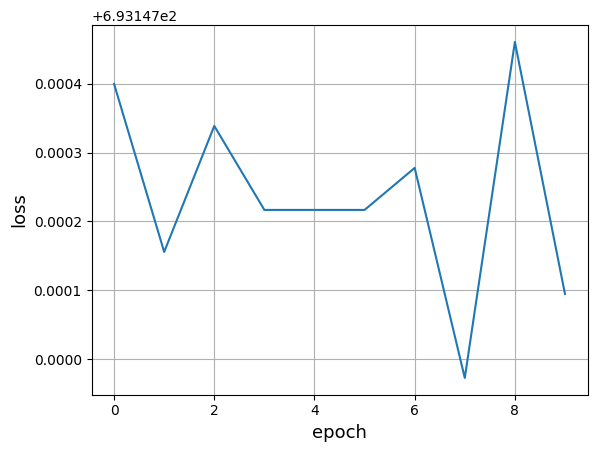

In [71]:
fig = plt.figure(1)	#identifies the figure 
#plt.title("Y vs X", fontsize='16')	#title
plt.plot([i for i in range(episode)], loss_list)	#plot the points
plt.xlabel("epoch",fontsize='13')	#adds a label in the x axis
plt.ylabel("loss",fontsize='13')	#adds a label in the y axis
#plt.legend(('YvsX'),loc='best')	#creates a legend to identify the plot
plt.savefig('try_loss.png')	#saves the figure in the present directory
plt.grid()	#shows a grid under the plot
plt.show()

# predict test data

In [3]:
## create graph
# edge_index.shpae = [2,num_nodes]

df = pd.read_csv('hw1_data/Synthetic/5000/4.txt', sep="\t", header=None)
edge_index = torch.tensor(np.array(df).T, dtype=torch.long)
num_nodes  = torch.unique(edge_index).shape
graph = Data(edge_index=edge_index,num_nodes=num_nodes[0])
score = pd.read_csv('hw1_data/Synthetic/5000/4_score.txt', sep="\t", header=None)
score = torch.tensor(score[1].values)

In [74]:
pred,loss_list =Drbc.predict(graph,score,graph.num_nodes)

In [85]:

acc = evaluate(pred, score, 1)
print('Top-1 Accuracy on the test data is : ' + str(acc))

acc = evaluate(pred, score, 5)
print('Top-5 Accuracy on the test data is : ' + str(acc))

acc = evaluate(pred, score, 10)
print('Top-10 Accuracy on the test data is : ' + str(acc))

tau, p_value  = kendalltau(pred.argsort().detach().numpy(), score.argsort().detach().numpy())
print('Kendall tau distance is : '+str(round(tau,4)))

Top-1 Accuracy on the test data is : 0.0
Top-5 Accuracy on the test data is : 0.012
Top-10 Accuracy on the test data is : 0.012
Kendall tau distance is : 0.2707


# Pipeline

In [29]:
train_config ={'EMBEDDING_SIZE' : 16,
               'node_default_dim' : 3,  # [degree, 1, 1]
                'encoder_layer' : 5,
                'num_nodes' : None,
                'batch' : 1,
                'episode' : 10,}


#將預測結果輸出至txt檔
with open('output.txt', 'w') as f:


    scale = [100,200,300,400,500]#,1000,3000]
    
    for i in scale:
        top1 = []
        top5 = []
        top10 = []
        K_tau = []
        kadabra_score = []
        
        pred_time = []
        train_config['num_nodes']= i 
        
        
        
        
        f.write('scale size = '+str(i)+"\n")
        f.write(json.dumps(train_config))
        f.write("\n")
        f.write("\n")
        # train
        start = time.time()
        Drbc = DrBC(train_config['EMBEDDING_SIZE'],
                    train_config['node_default_dim'],
                    train_config['encoder_layer'],
                    train_config['batch'])
        pred,loss_list = Drbc.train(train_config['episode'],train_config['num_nodes'])
        end = time.time()
        f.write('running time = '+str(end-start)+"\n")
        f.write("\n")
        torch.save(Drbc,f'Drbc{train_config["num_nodes"]}.pt')
        
        # loss plot
        fig = plt.figure(1)	#identifies the figure 
        plt.plot([i for i in range(train_config['episode'])], loss_list)
        plt.xlabel("epoch",fontsize='13')
        plt.ylabel("loss",fontsize='13')
        plt.grid()
        plt.savefig(f'scale{i}_loss.png')
        plt.clf()
        
        # predict
        
        for j in range(3):
            
            f.write('test on data '+str(j)+"\n")
            f.write("\n")
            df = pd.read_csv(f'hw1_data/Synthetic/5000/{j}.txt', sep="\t", header=None)
            edge_index = torch.tensor(np.array(df).T, dtype=torch.long)
            num_nodes  = torch.unique(edge_index).shape
            graph = Data(edge_index=edge_index,num_nodes=num_nodes[0])
            score = pd.read_csv(f'hw1_data/Synthetic/5000/{j}_score.txt', sep="\t", header=None)
            score = torch.tensor(score[1].values)
            
            start = time.time()
            pred,loss_list =Drbc.predict(graph,score,graph.num_nodes)
            end = time.time()
            pred_time.append(end-start)
            print(pred.unique())
            
            acc = evaluate(pred, score, 1)
            top1.append(acc)
            f.write(f'Top-1 Accuracy on the test data {j} is : ' + str(acc)+"\n")

            acc = evaluate(pred, score, 5)
            top5.append(acc)
            f.write(f'Top-5 Accuracy on the test data {j} is : ' + str(acc)+"\n")

            acc = evaluate(pred, score, 10)
            top10.append(acc)
            f.write(f'Top-10 Accuracy on the test data {j} is : ' + str(acc)+"\n")

            tau, p_value  = kendalltau(pred.argsort().detach().numpy(), score.argsort().detach().numpy())
            K_tau.append(tau)
            f.write('Kendall tau distance is : '+str(round(tau,4))+"\n")
            
            gra = Graph()
            gra.addNodes(num_nodes[0])
            for k in range(df.shape[0]):
                gra.addEdge(np.array(df)[k][0],np.array(df)[k][1])
            
            kadabra = KadabraBetweenness(gra,err = 0.01, delta = 0.1, k = 0,).run().scores()
            kada_s = sum(kadabra)/len(kadabra)
            kadabra_score.append(kada_s)
            f.write('kadabra score on test data:'+str(kada_s)+"\n")
            f.write("\n")
            
        top1_mean = round(sum(top1)/len(top1),4)
        f.write('mean of top1 accuracy is : '+str(top1_mean)+"\n")
        top5_mean = round(sum(top5)/len(top5),4)
        f.write('mean of top5 accuracy is : '+str(top5_mean)+"\n")
        top10_mean = round(sum(top10)/len(top10),4)
        f.write('mean of top10 accuracy is : '+str(top10_mean)+"\n")
        K_tau_mean = round(sum(K_tau)/len(K_tau),4)
        f.write('mean of tau accuracy is : '+str(K_tau_mean)+"\n")
        kadabra_score_mean = round(sum(kadabra_score)/len(kadabra_score),4)
        f.write('mean of kadabra accuracy is : '+str(kadabra_score_mean)+"\n")
        f.write("\n")
        
        average_time = round(sum(pred_time)/len(pred_time),4)
        f.write('average predict time = '+str(average_time)+"\n")
        f.write("\n")

tensor([0.], grad_fn=<Unique2Backward0>)
tensor([0.], grad_fn=<Unique2Backward0>)
tensor([0.], grad_fn=<Unique2Backward0>)
tensor([0.], grad_fn=<Unique2Backward0>)
tensor([0.], grad_fn=<Unique2Backward0>)
tensor([0.], grad_fn=<Unique2Backward0>)
tensor([0.0033, 0.0042, 0.0047,  ..., 0.0298, 0.0307, 0.0314],
       grad_fn=<Unique2Backward0>)
tensor([0.0024, 0.0033, 0.0042,  ..., 0.0303, 0.0316, 0.0322],
       grad_fn=<Unique2Backward0>)
tensor([0.0024, 0.0033, 0.0042,  ..., 0.0287, 0.0291, 0.0318],
       grad_fn=<Unique2Backward0>)
tensor([-8.1064e-05, -7.6240e-05, -7.0148e-05, -6.5573e-05, -5.8118e-05,
        -5.7571e-05, -5.5519e-05, -5.0345e-05, -4.9869e-05, -4.9866e-05,
        -4.9801e-05, -4.9685e-05, -4.9581e-05, -4.9578e-05, -4.9574e-05,
        -4.9249e-05, -4.9244e-05, -4.9131e-05, -4.8909e-05, -4.8907e-05,
        -4.8801e-05, -4.8686e-05, -4.8686e-05, -4.8686e-05, -4.8684e-05,
        -4.8615e-05, -4.8575e-05, -4.8573e-05, -4.8461e-05, -4.8356e-05,
        -4.8348e-05, -

<Figure size 640x480 with 0 Axes>

In [24]:
pred,loss_list =Drbc.predict(graph,score,graph.num_nodes)
pred.unique()

tensor([-1.1842e-04, -1.1842e-04, -1.1830e-04, -1.1830e-04, -1.1828e-04,
        -1.1828e-04, -1.1826e-04, -1.1824e-04, -1.1822e-04, -1.1663e-04,
        -1.1577e-04, -1.1576e-04, -1.1493e-04, -1.1487e-04, -1.1466e-04,
        -1.1438e-04, -1.1432e-04, -1.1418e-04, -1.1374e-04, -1.1369e-04,
        -1.1352e-04, -1.1350e-04, -1.1337e-04, -1.1320e-04, -1.1315e-04,
        -1.1308e-04, -1.1306e-04, -1.1300e-04, -1.1283e-04, -1.1283e-04,
        -1.1278e-04, -1.1272e-04, -1.1258e-04, -1.1255e-04, -1.1253e-04,
        -1.1253e-04, -1.1250e-04, -1.1249e-04, -1.1249e-04, -1.1249e-04,
        -1.1247e-04, -1.1243e-04, -1.1242e-04, -1.1237e-04, -1.1230e-04,
        -1.1229e-04, -1.1229e-04, -1.1226e-04, -1.1222e-04, -1.1220e-04,
        -1.1219e-04, -1.1215e-04, -1.1195e-04, -1.1178e-04, -1.1168e-04,
        -1.1167e-04, -1.1164e-04, -1.1160e-04, -1.1147e-04, -1.1146e-04,
        -1.1123e-04, -1.1064e-04, -1.1055e-04, -1.1053e-04, -1.1034e-04,
        -1.1034e-04, -1.1030e-04, -1.0986e-04, -1.0

In [12]:
loss_list

[17328.67780138949]

In [127]:
import json

# as requested in comment
train_config ={'EMBEDDING_SIZE' : 12,
               'node_default_dim' : 3 , # [degree, 1, 1]
                'encoder_layer' : 5,
                'num_nodes' : None,
                'batch' : 1,
                'episode' : 100,}


with open('file.txt', 'w') as file:
     file.write(json.dumps(train_config))

In [17]:
DrBC_model200_10000 = DrBC_model

In [8]:
DrBC_model[0]

In [22]:
round(sum(top10)/len(top10),4)

0.0005

In [7]:
DrbC

NameError: name 'DrbC' is not defined

In [13]:
torch.save(Drbc,'Drbc.pt')

In [20]:
Drbc__ = DrBC(train_config['EMBEDDING_SIZE'],
                    train_config['node_default_dim'],
                    train_config['encoder_layer'],
                    train_config['batch'])
Drbc__ = torch.load('Drbc.pt')

In [19]:
Drbc__.torch.load('Drbc.pt')

AttributeError: 'DrBC' object has no attribute 'load_state_dict'

In [21]:
Drbc__.predict(graph,score,graph.num_nodes)

(tensor([2.4077e-04, 2.0562e-04, 1.8109e-04,  ..., 2.8663e-06, 2.8663e-06,
         2.8663e-06], grad_fn=<ReshapeAliasBackward0>),
 [17328.67671143992])

In [13]:
Drbc__.predict(graph,score,graph.num_nodes)

(tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<ReshapeAliasBackward0>),
 [17328.67956161499])

In [15]:
Drbc.predict(graph,score,graph.num_nodes)

(tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<ReshapeAliasBackward0>),
 [17328.679647963516])